In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title Imports and Helper Functions
import numpy as np
from matplotlib import pyplot as plt

class Model:
    """Base class for models."""
    def __init__(self):
        """params is a dictionary mapping parameter names to numpy arrays"""
        self.params = {}

    def predict(self, X):
        """X is a numpy array of shape (N, D), where N is the number of
        D-dimensional data points"""
        raise NotImplementedError

    def loss(self, X, y):
        """X is a numpy array of shape (N, D) and y is a numpy array of shape (N,)"""
        raise NotImplementedError

    def grad(self, X, y):
        """X is a numpy array of shape (N, D) and y is a numpy array of shape (N,).
        This will be a matching dictionary to self.params, with all the same keys
        and for each parameter it will have the gradient which is a numpy array of
        the same shape"""
        raise NotImplementedError

def grad_check(model, X, y, eps = 1e-6):
    """Numerically estimate the gradient of the loss function and compare it to the analytical gradient"""
    grad = model.grad(X, y)
    for param in model.params:
        print(f"Checking {param}:")
        print(f"Analytical gradient {grad[param]}")
        assert grad[param].shape == model.params[param].shape, "Gradient shape mismatch"
        numgrad = np.zeros(grad[param].shape)
        for i, val in np.ndenumerate(model.params[param]):
            model.params[param][i] = val + eps
            loss1 = model.loss(X, y)
            model.params[param][i] = val - eps
            loss2 = model.loss(X, y)
            model.params[param][i] = val
            numgrad[i] = (loss1 - loss2) / (2 * eps)
        print(f"Numerical gradient {numgrad}")
        print(f"Difference {abs(numgrad - grad[param])}")
        print()

class Optimizer:
    def __init__(self, model):
        self.model = model

    def step(self, grad):
        raise NotImplementedError

class SGD(Optimizer):
    def __init__(self, model, learning_rate=1e-3):
        super().__init__(model)
        self.learning_rate = learning_rate

    def step(self, grad):
        for param in self.model.params:
            self.model.params[param] -= self.learning_rate * grad[param]

# Part 1: Binary Classifiers

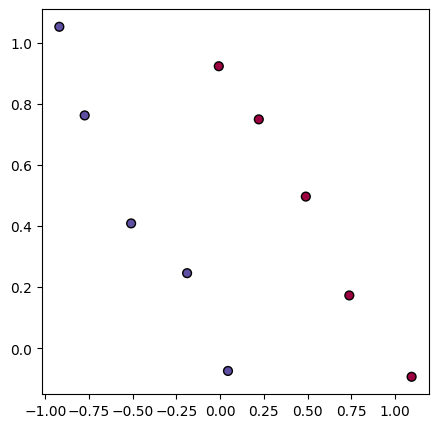

In [ ]:
def plot_2d_data(X, y):
    fig, ax = plt.subplots(figsize = (5, 5))
    ax.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolors='black')

def plot_2d_classifier(X, y, classifier):
    """Makes a scatter plot of the data points and a background of what the classifier does.
    X is a (n,2) array of data points.
        y is an (n,) array of labels.
        classifier is a function that takes a 2d points
         and gives a label."""
    border = 0.2
    x_min, x_max = X[:, 0].min() - border, X[:, 0].max() + border
    y_min, y_max = X[:, 1].min() - border, X[:, 1].max() + border
    num_points = 100
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, num_points),
                        np.linspace(y_min, y_max, num_points))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    classes = classifier(grid_points)
    classes = classes.reshape(xx.shape)
    fig = plt.figure(figsize = (6,6))
    plt.contourf(xx, yy, classes, 3, cmap=plt.cm.Spectral, alpha=1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

X1 = np.array([[ 1.09552218, -0.09272374],
       [ 0.73918262,  0.17328342],
       [ 0.49026465,  0.49654933],
       [ 0.22117347,  0.74908991],
       [-0.00771262,  0.9228498 ],
       [ 0.04485428, -0.07363758],
       [-0.18909266,  0.24609735],
       [-0.50931804,  0.40888908],
       [-0.77501111,  0.76200558],
       [-0.92010407,  1.0518896 ]])
y1 = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

plot_2d_data(X1, y1)

## Naive attempt: just use multiple regression

In [ ]:
class MultipleRegression(Model):
    def __init__(self, D, reg=0):
        super().__init__()
        W = np.zeros(D, dtype=float)
        b = np.array(0, dtype=float)
        self.reg = reg
        self.params = {"W": W, "b": b}

    def predict(self, X):
        return X @ self.params['W'] + self.params['b']



    def loss(self,X,y):
        loss = np.mean((self.predict(X) - y) ** 2)
        loss += self.reg * np.sum(self.params['W'] ** 2)
        return loss

    def grad(self, X, y):
        dW = np.mean(2*X*(X@self.params['W']+self.params['b']-y).reshape((len(X),1)),axis=0)+self.reg*2*(self.params['W'])
        db = np.mean(2*(X@self.params['W']+self.params['b']-y))
        return {"W": dW, "b": db}

    def exact(self,X,y):
        # Add bias row
        newX = np.concatenate((X,np.ones(len(X)).reshape((len(X),1))),axis=1)

        # Create identity matrix for reg term
        idenmatrix = np.identity(len(self.params['W'])+1)
        idenmatrix[len(self.params['W']),len(self.params['W'])]=0

        # Regularization term
        regterm = len(X)*self.reg*idenmatrix

        # Get the answer
        explicit=np.linalg.inv(newX.T @ newX + regterm) @ newX.T @ y
        return {"W":explicit[:-1], "b":explicit[-1]}

    def classify(self, X):
        return self.predict(X) > 0.5

# you can then fit X1 and y1 and see the result using
# plot_2d_classifier(X1, y1, m.classify)

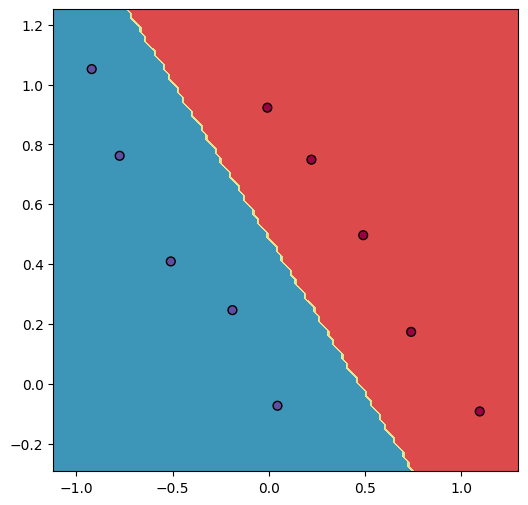

In [ ]:
m = MultipleRegression(2)
m.params = m.exact(X1,y1)
plot_2d_classifier(X1, y1, m.classify)

This first example should actually work pretty well. To see why this method is more generally flawed, here's another dataset:

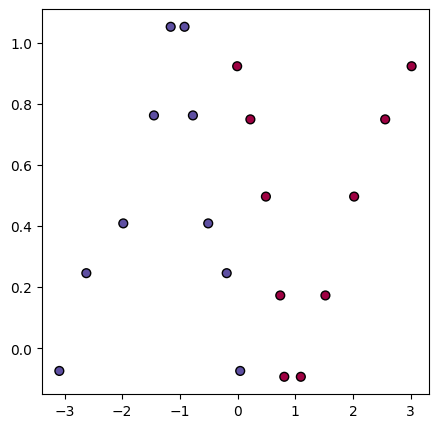

In [ ]:
X2 = np.array([[ 0.80895564, -0.09272374],
       [ 1.52163476,  0.17328342],
       [ 2.0194707 ,  0.49654933],
       [ 2.55765306,  0.74908991],
       [ 3.01542524,  0.9228498 ],
       [-3.08970856, -0.07363758],
       [-2.62181468,  0.24609735],
       [-1.98136392,  0.40888908],
       [-1.44997778,  0.76200558],
       [-1.15979186,  1.0518896 ]])
X2 = np.concatenate([X1, X2])
y2 = np.concatenate([y1, y1])

plot_2d_data(X2, y2)

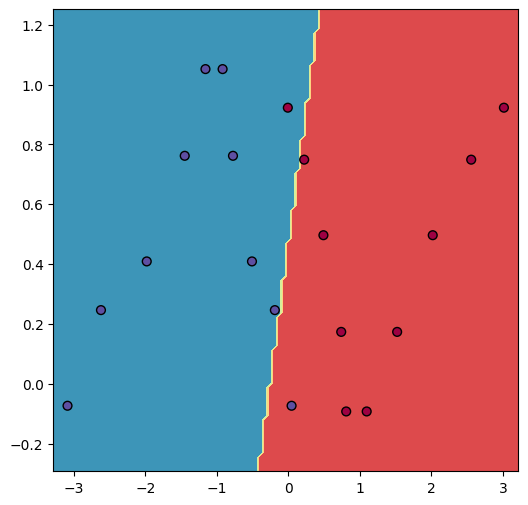

In [ ]:
m2 = MultipleRegression(2)
m2.params = m.exact(X2,y2)
plot_2d_classifier(X2, y2, m2.classify)

## Actual Solution: Logistic "Regression"

In [ ]:
class LogisticRegression(Model):
  def __init__(self, D, reg=0):
    super().__init__()
    W = np.zeros(D, dtype=float)
    b = np.array(0, dtype=float)
    self.reg = reg
    self.params = {"W": W, "b": b}

  def predict(self,X):
    return X @ self.params['W'] + self.params['b']

  # positive output is one class, negative is the other
  def classify(self,X):
    return self.predict(X)>0

  def probs(self,X):
    return self.sigmoid(self.predict(X))

  def sigmoid(self,X):
    return np.exp(X)/(1+np.exp(X))

  def loss(self,X,y):
    probs_of_correct_values = y*self.probs(X)-y/2.0+0.5
    return -np.log(probs_of_correct_values).mean()

  def grad(self,X,y):
    dW = np.mean((-1/(y*self.probs(X)-y/2.0+0.5)*y*(self.sigmoid(self.predict(X)))*(1-self.sigmoid(self.predict(X)))).reshape(len(X),1)*X,axis=0)
    db = np.mean(-1/(y*self.probs(X)-y/2.0+0.5)*y*(self.sigmoid(self.predict(X)))*(1-self.sigmoid(self.predict(X))))
    return {"W":dW,"b":db}



In [ ]:
l = LogisticRegression(2)
grad_check(l, X1, y1, eps = 1e-6)

Checking W:
Analytical gradient [ 0.11743358 -0.1197622 ]
Numerical gradient [ 0.11743358 -0.1197622 ]
Difference [2.69154976e-11 4.47486076e-11]

Checking b:
Analytical gradient -0.25
Numerical gradient -0.24999999997943334
Difference 2.05666594865761e-11



# Part 2: Linear Classifier on 2D Test Data

Get an 2D X and y with where now y has more than 2 possible classes. A good example is the very first dataset you created back on the first assignment, which should look something like this:

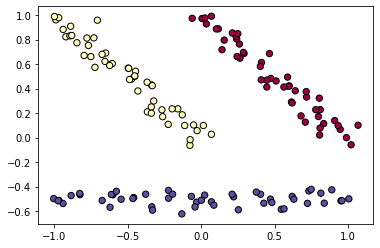

In [3]:
class LinearClassifier(Model):
    def __init__(self, input_dim, output_dim, reg=0):
        W = np.zeros((input_dim, output_dim))
        b = np.zeros(output_dim)
        self.params = {'W': W, 'b': b}
        self.reg = reg

    def predict(self, X):
        return X @ self.params['W'] + self.params['b']

    def classify(self, X):
        scores = self.predict(X)
        return np.argmax(scores, axis=1)

    def probs(self,X):
        scores = self.predict(X)
        expscores = np.exp(scores-np.max(scores,axis=1,keepdims=True))
        return expscores/np.sum(expscores,axis=1,keepdims=True)

    def loss(self, X, y):
        correct_probs = self.probs(X)[np.arange(len(X)),y]
        return -np.log(correct_probs).mean()+ self.reg*np.sum(self.params['W'] ** 2)

    def grad(self, X, y):
        dLds = self.probs(X)
        dLds[np.arange(len(X)),y] -= 1
        dW = (X.T @ dLds)/len(X)+self.reg*2*self.params['W']
        db = np.mean(dLds,axis=0)
        return {"W":dW, "b":db}

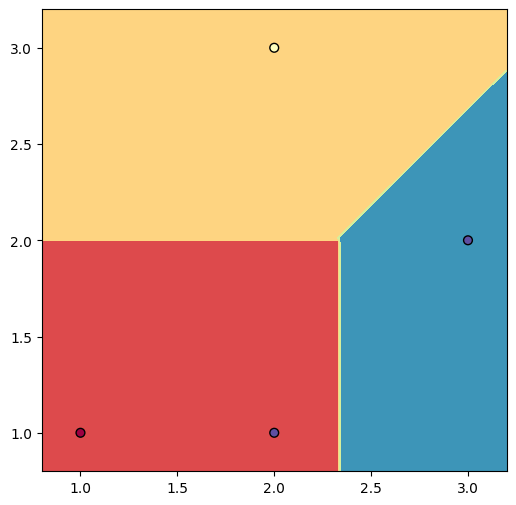

In [ ]:
## A class example we will use
X3 = np.array([[1,1],
              [2,1],
              [3,2],
              [2,3]]).astype(float)
y3 = np.array([0,2,2,1])
m = LinearClassifier(2, 3, reg=0.1)
m.params['W'] = np.array([[-2,-2,1],
                          [-1,2,-1]],).astype(float)
m.params['b'] = np.array([4,-2,-3]).astype(float)
plot_2d_classifier(X3, y3, m.classify)

In [ ]:
grad_check(m,X3,y3)

Checking W:
Analytical gradient [[ 0.03993869 -0.32278732 -0.31715137]
 [ 0.04861897  0.42586607 -0.47448504]]
Numerical gradient [[ 0.03993869 -0.32278732 -0.31715137]
 [ 0.04861897  0.42586607 -0.47448504]]
Difference [[3.15542037e-12 1.30032096e-11 7.40568717e-12]
 [8.88794316e-11 1.04953712e-10 2.82113777e-11]]

Checking b:
Analytical gradient [ 0.19868592  0.03111955 -0.22980546]
Numerical gradient [ 0.19868592  0.03111955 -0.22980546]
Difference [2.09037510e-11 7.97391597e-11 5.88354920e-11]



Loss: 0.6784659750518905


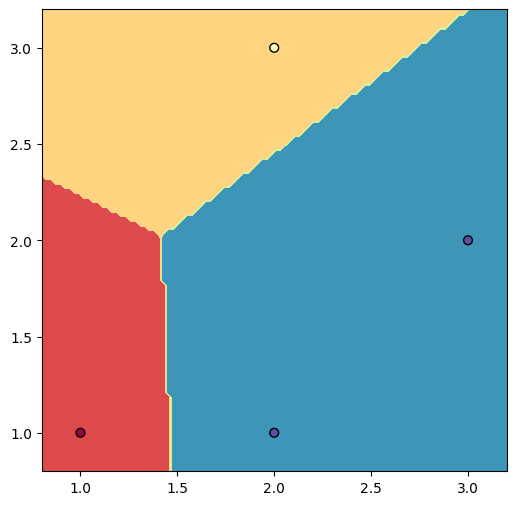

In [ ]:
#Optimized Model
optimizer = SGD(m,1e-1)
for x in range(0,500):
  optimizer.step(m.grad(X3,y3))

print("Loss: "+str(m.loss(X3,y3)))
plot_2d_classifier(X3, y3, m.classify)

# Part 3: Linear Classifiers on MNIST / CIFAR-10

In [4]:
#@title helpful training function
import pickle

def train(model, X_train, y_train, num_epochs = 50,
          print_every = 1,
          batch_size = None, optimizer = None,
          X_val = None, y_val = None,
          save_path='best_model.pkl'):

    if optimizer is None:
        optimizer = SGD(model)
    if batch_size is None:
        batch_size = X_train.shape[0]

    if X_val is not None:
        best_val_acc = np.mean(model.classify(X_val) == y_val)

    for epoch in range(num_epochs):

        if epoch % print_every == 0:
            print(f"Epoch {epoch}:")
            print(f"Train Loss = {model.loss(X_train, y_train)}")
            print(f"Train Accuracy = {np.mean(model.classify(X_train) == y_train)}")
            if X_val is not None:
                print(f"Val Loss = {model.loss(X_val, y_val)}")
                val_acc = np.mean(model.classify(X_val) == y_val)
                print(f"Val Accuracy = {val_acc}")
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    with open(save_path, 'wb') as f:
                        pickle.dump(model, f)

        # split into batches and loop over batches
        indices = np.random.permutation(X_train.shape[0])
        num_batches = X_train.shape[0] // batch_size
        batch_indices = np.array_split(indices, num_batches)
        for batch in batch_indices:
            optimizer.step(model.grad(X_train[batch], y_train[batch]))

In [ ]:
#@title Function to Visualize the Weights for MNIST
from matplotlib.colors import TwoSlopeNorm

def visualize_weights(m: LinearClassifier):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    for i, ax in enumerate(axes.flat):
        im = ax.imshow(m.params['W'][:,i].reshape(28, 28),
                      cmap='RdBu_r',
                      norm=TwoSlopeNorm(vcenter=0))
        plt.colorbar(im, ax=ax)
        ax.set_title(f'Weights for {i}')
        # Remove axis numbers
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

In [ ]:
#@title MNIST Set Creator
from keras.datasets import mnist
(mnist_t_X, mnist_t_y), (mnist_test_X, mnist_test_y) = mnist.load_data()
mnist_t_X=mnist_t_X.reshape(len(mnist_t_X),784)
mnist_test_X=mnist_test_X.reshape(len(mnist_test_X),784)
indices = np.arange(len(mnist_t_X))
np.random.shuffle(indices)
mnist_train_X, mnist_train_y, mnist_val_X, mnist_val_y = mnist_t_X[indices[:int(0.8*len(indices))]], mnist_t_y[indices[:int(0.8*len(indices))]], mnist_t_X[indices[int(0.8*len(indices)):]], mnist_t_y[indices[int(0.8*len(indices)):]]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#@title MNIST Model
mnistmodel = LinearClassifier(784,10,reg=0.1)
train(mnistmodel,mnist_train_X,mnist_train_y,batch_size=1000,optimizer=SGD(mnistmodel,1e-5),X_val=mnist_val_X,y_val=mnist_val_y,save_path="/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/mnist_model.pkl")

Epoch 0:
Train Loss = 2.3025850929940455
Train Accuracy = 0.09952083333333334
Val Loss = 2.3025850929940455
Val Accuracy = 0.0955
Epoch 1:
Train Loss = 0.4356178610227544
Train Accuracy = 0.8834791666666667
Val Loss = 0.4443324753861756
Val Accuracy = 0.8825833333333334
Epoch 2:
Train Loss = 0.3797515451014382
Train Accuracy = 0.8960625
Val Loss = 0.3919445645714529
Val Accuracy = 0.8945833333333333
Epoch 3:
Train Loss = 0.35251730400769876
Train Accuracy = 0.9017708333333333
Val Loss = 0.36760319729276203
Val Accuracy = 0.89975
Epoch 4:
Train Loss = 0.33763390604214977
Train Accuracy = 0.90625
Val Loss = 0.35442571446617716
Val Accuracy = 0.9020833333333333
Epoch 5:
Train Loss = 0.3273683483332059
Train Accuracy = 0.9088541666666666
Val Loss = 0.34556291542791673
Val Accuracy = 0.9058333333333334
Epoch 6:
Train Loss = 0.3198133398770154
Train Accuracy = 0.9106666666666666
Val Loss = 0.33966862418183463
Val Accuracy = 0.906
Epoch 7:
Train Loss = 0.31505218089742737
Train Accuracy = 0.9

Accuracy: 0.922


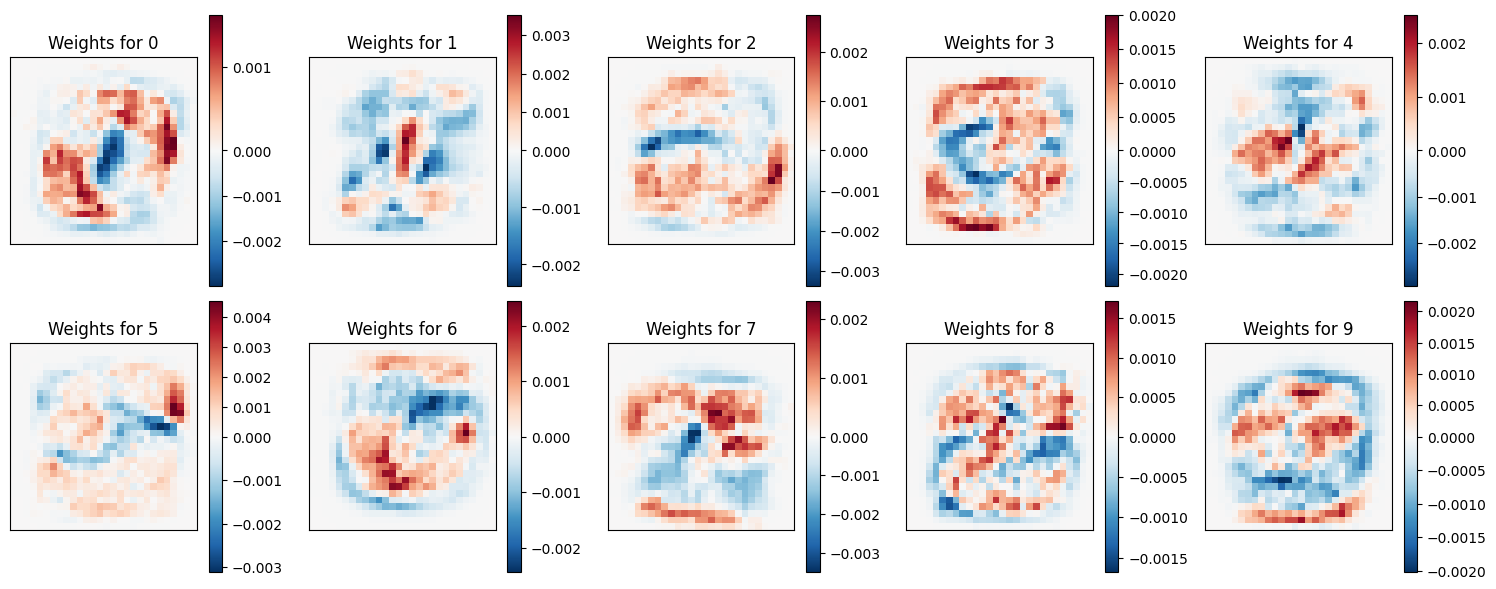

In [ ]:
#@title Results for Mnist
print("Accuracy: "+str(np.mean(mnistmodel.classify(mnist_test_X) == mnist_test_y)))
visualize_weights(mnistmodel)

In [ ]:
#@title Function to Visualize the Weights for CIFAR
from matplotlib.colors import TwoSlopeNorm

def visualize_weights2(m: LinearClassifier):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    for i, ax in enumerate(axes.flat):
        im = ax.imshow(np.concatenate((m.params['W'][:,i][np.arange(0,1024)*3].reshape(32,32),m.params['W'][:,i][np.arange(0,1024)*3+1].reshape(32,32),m.params['W'][:,i][np.arange(0,1024)*3+2].reshape(32,32))),
                      cmap='RdBu_r',
                      norm=TwoSlopeNorm(vcenter=0))
        plt.colorbar(im, ax=ax)
        ax.set_title(f'Weights for {i}')
        # Remove axis numbers
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def visualize_weights_cifar(m: LinearClassifier):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    wmin, wmax = np.min(m.params['W']), np.max(m.params['W'])
    for i, ax in enumerate(axes.flat):
        im = ax.imshow((m.params['W'][:,i].reshape(32, 32, 3) - wmin) / (wmax - wmin))
        ax.set_title(f'Weights for {classes[i]}')
        # Remove axis numbers
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

In [ ]:
#@title CIFAR Set Creator
from keras.datasets import cifar10
(cifar_t_X, cifar_t_y), (cifar_test_X, cifar_test_y) = cifar10.load_data()
cifar_t_X = cifar_t_X[:10000].astype(float)
cifar_t_y = cifar_t_y[:10000]
cifar_t_y = cifar_t_y.reshape(len(cifar_t_y))
cifar_test_y = cifar_test_y[:2000]
cifar_test_X = cifar_test_X[:2000].astype(float)
cifar_test_y = cifar_test_y.reshape(len(cifar_test_y))
cifar_t_X=cifar_t_X.reshape(len(cifar_t_X),3072)
cifar_test_X=cifar_test_X.reshape(len(cifar_test_X),3072)
indices = np.arange(len(cifar_t_X))
np.random.shuffle(indices)
cifar_train_X, cifar_train_y, cifar_val_X, cifar_val_y = cifar_t_X[indices[:int(0.8*len(indices))]], cifar_t_y[indices[:int(0.8*len(indices))]], cifar_t_X[indices[int(0.8*len(indices)):]], cifar_t_y[indices[int(0.8*len(indices)):]]

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
#@title CIFAR Model
cifarmodel = LinearClassifier(3072,10,reg=0)
train(cifarmodel,cifar_train_X,cifar_train_y,num_epochs=200,batch_size=1000,optimizer=SGD(cifarmodel,1e-7),X_val=cifar_val_X,y_val=cifar_val_y,save_path="/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/cifar_model.pkl")

Epoch 0:
Train Loss = 2.302585092994045
Train Accuracy = 0.0995
Val Loss = 2.302585092994045
Val Accuracy = 0.1045
Epoch 1:
Train Loss = 2.257760834886553
Train Accuracy = 0.129875
Val Loss = 2.263649027801733
Val Accuracy = 0.1235
Epoch 2:
Train Loss = 2.2231527697916587
Train Accuracy = 0.208625
Val Loss = 2.2308385951904595
Val Accuracy = 0.1835
Epoch 3:
Train Loss = 2.192985424561408
Train Accuracy = 0.222125
Val Loss = 2.202770665453255
Val Accuracy = 0.2105
Epoch 4:
Train Loss = 2.168627709306857
Train Accuracy = 0.25175
Val Loss = 2.181195689952638
Val Accuracy = 0.2315
Epoch 5:
Train Loss = 2.146128412283764
Train Accuracy = 0.26725
Val Loss = 2.161551798335394
Val Accuracy = 0.2415
Epoch 6:
Train Loss = 2.1273454078203304
Train Accuracy = 0.276375
Val Loss = 2.14338765052867
Val Accuracy = 0.257
Epoch 7:
Train Loss = 2.1106698278882092
Train Accuracy = 0.274625
Val Loss = 2.12664738145531
Val Accuracy = 0.262
Epoch 8:
Train Loss = 2.094535373622195
Train Accuracy = 0.308
Val L

Accuracy: 0.376


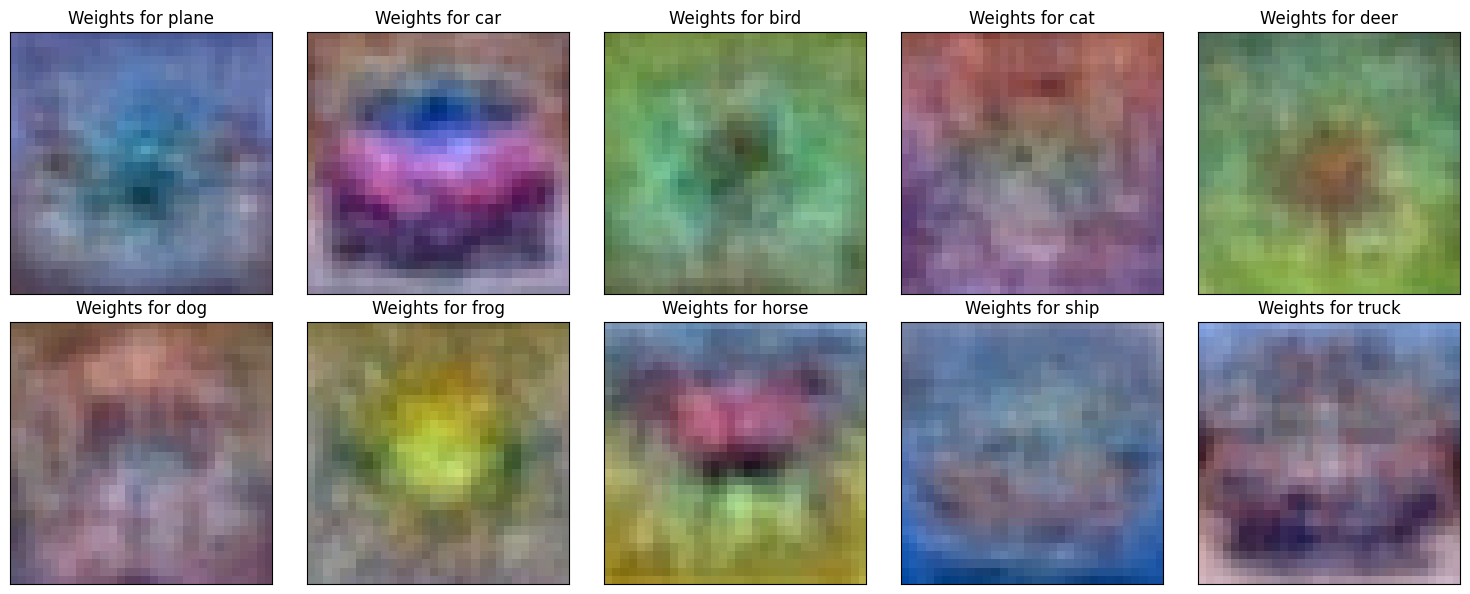

In [ ]:
#@title Results for Mnist
print("Accuracy: "+str(np.mean(cifarmodel.classify(cifar_test_X) == cifar_test_y)))
visualize_weights_cifar(cifarmodel)

# Part 4: Linear Classifiers on Word Dataset

Now we will see how to go interpret the bigram next token prediction as a linear model, and see solution the linear classifier finds

In [17]:
# Toy Dataset
words = ["a",
         "ab",
         "baba",
         "baa",
         "aa",
         "abba",
         "bab",
         "aba",
         "aaa"]
n=2
num_letters = 3
letter_encodings = {"$":0, "a":1, "b":2}
letter_encodings2 = {0:[1,0,0], 1:[0,1,0], 2:[0,0,1]}

padded_words = [[letter_encodings[l] for l in list((n-1)*'$' + w + '$')] for w in words]
train_words = padded_words[:6]
test_words = padded_words[6:]

X_words = []
y_words = []
for word in train_words:
  for index in range(len(word)-(n-1)):
    token = []
    for i in range(n-1):
      token += letter_encodings2[word[index+i]]
    X_words.append(token)
    y_words.append(word[index+(n-1)])

X_words = np.array(X_words)
y_words = np.array(y_words)
print("Train X: "+str(X_words))
print("Train y: "+str(y_words))


Train X: [[1 0 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]]
Train y: [1 0 1 2 0 2 1 2 1 0 2 1 1 0 1 1 0 1 2 2 1 0]


In [6]:
# Toy dataset classifier
textclassifier = LinearClassifier((n-1)*num_letters, num_letters)

In [7]:
train(textclassifier,X_words,y_words,num_epochs=600)

Epoch 0:
Train Loss = 1.09861228866811
Train Accuracy = 0.2727272727272727
Epoch 1:
Train Loss = 1.0985516896617065
Train Accuracy = 0.45454545454545453
Epoch 2:
Train Loss = 1.0984911188634603
Train Accuracy = 0.45454545454545453
Epoch 3:
Train Loss = 1.098430576256452
Train Accuracy = 0.45454545454545453
Epoch 4:
Train Loss = 1.0983700618237702
Train Accuracy = 0.45454545454545453
Epoch 5:
Train Loss = 1.0983095755485144
Train Accuracy = 0.45454545454545453
Epoch 6:
Train Loss = 1.0982491174137943
Train Accuracy = 0.45454545454545453
Epoch 7:
Train Loss = 1.0981886874027282
Train Accuracy = 0.45454545454545453
Epoch 8:
Train Loss = 1.0981282854984438
Train Accuracy = 0.45454545454545453
Epoch 9:
Train Loss = 1.0980679116840784
Train Accuracy = 0.45454545454545453
Epoch 10:
Train Loss = 1.098007565942779
Train Accuracy = 0.45454545454545453
Epoch 11:
Train Loss = 1.097947248257702
Train Accuracy = 0.45454545454545453
Epoch 12:
Train Loss = 1.0978869586120137
Train Accuracy = 0.4545454

In [8]:
# Toy dataset params
print(textclassifier.params)

{'W': array([[-0.0521805 ,  0.05123205,  0.00094845],
       [ 0.04495899, -0.03772429, -0.0072347 ],
       [-0.02560576,  0.0512275 , -0.02562174]]), 'b': array([-0.03282728,  0.06473527, -0.03190799])}


In [9]:
# Creates text dataset out of series of words
def create_text_dataset(words,n,trainpart=0.6,valpart=0.2):
  translist = [(n-1)*["$"]+list(word)+["$"] for word in words]
  letter_encodings = {}
  numletters = 0
  for word in translist:
    for letter in word:
      if letter not in letter_encodings:
        letter_encodings[letter] = numletters
        numletters += 1
  letter_encodings2 = {}
  for letter in letter_encodings:
    row = np.zeros(numletters)
    row[letter_encodings[letter]] = 1
    letter_encodings2[letter] = row

  X_words = []
  y_words = []
  for word in words:
    token = None
    for index in range(len(word)-(n-1)):
      if token is None:
        token = np.tile(letter_encodings2[word[0]],n-1)
      else:
        token = np.concatenate((token[numletters:],letter_encodings2[word[index+(n-2)]]))
      X_words.append(token)
      y_words.append(letter_encodings[word[index+(n-1)]])

  X_words = np.array(X_words)
  y_words = np.array(y_words).astype(int)

  indices = np.arange(len(X_words))

  np.random.shuffle(indices)
  train = indices[:int(trainpart*len(indices))]
  val = indices[int(trainpart*len(indices)):int((trainpart+valpart)*len(indices))]
  test = indices[int((trainpart+valpart)*len(indices)):]

  return letter_encodings, X_words[train], y_words[train], X_words[val], y_words[val], X_words[test], y_words[test]

In [10]:
# Creates text dataset out of astronomy data
astn = 3
f = open("/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/allasts.txt", "r")
asts = [line.strip() for line in list(f.readlines())]
ast = create_text_dataset(asts, astn)

In [11]:
# Training classifier
astclassifier = LinearClassifier((astn-1)*len(ast[0]),len(ast[0]))
train(astclassifier,ast[1],ast[2],num_epochs=200,batch_size=100,X_val=ast[3],y_val=ast[4])

Epoch 0:
Train Loss = 4.33073334028633
Train Accuracy = 0.0
Val Loss = 4.33073334028633
Val Accuracy = 0.0
Epoch 1:
Train Loss = 4.309495524904769
Train Accuracy = 0.16492487281618487
Val Loss = 4.309747730857242
Val Accuracy = 0.16379769299023958
Epoch 2:
Train Loss = 4.2885272511313985
Train Accuracy = 0.16494459123713373
Val Loss = 4.28902988232019
Val Accuracy = 0.16379769299023958
Epoch 3:
Train Loss = 4.267836155516527
Train Accuracy = 0.16504318334187798
Val Loss = 4.268587342987457
Val Accuracy = 0.16391600118308192
Epoch 4:
Train Loss = 4.247426434714544
Train Accuracy = 0.1651614938675711
Val Loss = 4.248424286755211
Val Accuracy = 0.16415261756876665
Epoch 5:
Train Loss = 4.227304468905746
Train Accuracy = 0.1651614938675711
Val Loss = 4.228546982832957
Val Accuracy = 0.16415261756876665
Epoch 6:
Train Loss = 4.207475561517318
Train Accuracy = 0.1651220570256734
Val Loss = 4.208960686839886
Val Accuracy = 0.16421177166518783
Epoch 7:
Train Loss = 4.187945790013489
Train Accu

In [12]:
# params for astronomy dataset
print(astclassifier.params)

{'W': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.13559489e-02, -3.34478737e-02, -1.48184828e-02, ...,
        -2.22551766e-02, -2.13696987e-02, -2.13559489e-02],
       [-2.68587067e-03,  2.34221474e-02, -1.11734294e-03, ...,
         1.19156249e-03, -2.68762900e-03, -2.68587067e-03],
       ...,
       [-8.50855572e-04, -1.87947030e-03, -9.91585483e-04, ...,
         1.10987825e-03, -8.51420215e-04, -8.50855572e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.45621495e-05, -3.20057772e-05, -1.68885257e-05, ...,
        -1.51810680e-05, -1.45717591e-05, -1.45621495e-05]]), 'b': array([-0.69006914,  0.7273174 , -0.36693857,  0.47672936,  2.60073376,
       -0.48677833,  0.10580756,  0.22147152,  0.54809344, -0.26660533,
        0.09629012,  0.23424161,  0.17310622, -0.30696571,  0.37166417,
        0.68841

In [14]:
# Generates word using classifier
def generate_word(textclassifier, letter_encodings):
  n = int(textclassifier.params["W"].shape[0]/len(letter_encodings)+1)
  token = np.tile(np.array([0]*(len(letter_encodings))),n-1)
  letter = None
  outlst = []
  while letter != "$":
    newletter = textclassifier.classify(np.array([token]))
    lettersymb = np.zeros(len(letter_encodings))
    lettersymb[newletter] = 1
    token = np.concatenate((token[len(letter_encodings):],lettersymb))
    for lett in letter_encodings:
      if letter_encodings[lett] == newletter:
        letter = lett
        break
    outlst.append(letter)
    print(letter,end='')
  return "".join(outlist[:-1])

In [15]:
generate_word(astclassifier,ast[0])

 120202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020

KeyboardInterrupt: 

# Sources and Reflection
Thomas for the gradients

https://stackoverflow.com/questions/22634265/python-concatenate-or-clone-a-numpy-array-n-times

https://www.geeksforgeeks.org/print-without-newline-python/https://www.geeksforgeeks.org/print-without-newline-python/